In [1]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("/Users/koushik/Documents/MP/datasets/RSICD/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [2]:
print(type(content))

<class 'dict'>


In [3]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 576232


In [4]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 2969


In [5]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [6]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 901


PREPARE TRAIN AND TEST DATA

In [7]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("/Users/koushik/Documents/MP/train_rscid.txt", 'r') as file:
    train_file_data = file.read()

with open ("/Users/koushik/Documents/MP/test_rscid.txt", 'r') as file:
    test_file_data = file.read()

In [8]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [9]:
train_data[2:10]

['airport_100',
 'airport_101',
 'airport_102',
 'airport_103',
 'airport_104',
 'airport_105',
 'airport_106',
 'airport_107']

In [10]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append =   caption 
        train_content[imageID].append(cap_to_append)

KeyError: ''

In [11]:
train_content['airport_103']

['some green trees are near a large piece of bareland ',
 'some planes are parked near an airport with parking lot ',
 'some planes are parked near an airport with parking lot ',
 'some green trees are near a large piece of bareland ',
 'some green trees are near a large piece of bareland ']

EXTRACT FEATURES FROM IMAGES USING RESNET50 ARCHIECTURE

In [12]:
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Load ResNet50 model without pre-trained weights
model = ResNet50(weights=None, input_shape=(224, 224, 3))


In [13]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [15]:
from keras.preprocessing import image
import numpy as np

def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


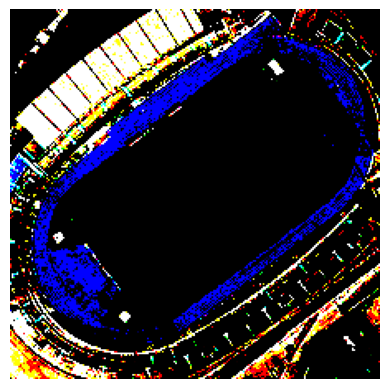

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

img = preprocess_image("/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/stadium_249.jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [17]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [18]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Encoding in progress... STEP 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/st

FileNotFoundError: [Errno 2] No such file or directory: '/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/.jpg'

In [19]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [20]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Encoding in progress... STEP 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━

In [21]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

PREPROCESS THE CAPTIONS

In [22]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [23]:
print(len(index_to_word))

901


In [24]:
print(index_to_word[5])
print(word_to_index['is'])

in
10


In [25]:
# Add startseq and endseq also to the mappings
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [26]:
print(VOCAB_SIZE)

904


In [27]:
import pickle
with open("/Users/koushik/Documents/MP/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [28]:
with open("/Users/koushik/Documents/MP/word_to_idx.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [29]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [30]:
print(max_len)

34


In [31]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("/Users/koushik/Documents/MP/glove.6B.50d.txt",encoding='utf8')

In [32]:
# Create a mapping from word to embedding
embeddings_index = {} # empty dictionary

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [33]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [34]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(904, 50)

DEFINE MODEL ARCHITECTURE

In [36]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [37]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

In [38]:
#from keras.layers.merge  import add
from keras.layers import add

# Decode the inputs

# So, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [39]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 50)    │     45,200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 904)       │    232,328 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,182,232 (4.51 MB)

 Trainable params: 1,182,232 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from graphviz import InvocationException

# Your code where you handle Graphviz errors


plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'graphviz'

In [46]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [47]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [48]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

TRAIN THE MODEL

In [2]:
epochs = 10
batch_size = 5
steps = len(train_content)//batch_size

NameError: name 'train_content' is not defined

In [70]:
def data_generator(train_content, train_encoding, word_to_index, max_len, batch_size, data_format='channels_last'):
    num_samples = len(train_content)
    indices = np.arange(num_samples)
    steps = num_samples // batch_size
    if num_samples % batch_size != 0:
        steps += 1

    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = list(indices[start:end])
            batch_content = []
            batch_encoding = []
            try:
                batch_content = [train_content[i] for i in batch_indices]
                batch_encoding = [train_encoding[i] for i in batch_indices]
            except KeyError as e:
                print(f"KeyError occurred: {e}")
                print(f"Invalid index: {e.args[0]}")
                print(f"batch_indices: {batch_indices}")
                print(f"len(train_content): {len(train_content)}")
                print(f"len(train_encoding): {len(train_encoding)}")
            
            # Modify this line to include the data_format argument
            batch_inputs = preprocess_input(batch_content, word_to_index, max_len, data_format) if max_len is not None else preprocess_input(batch_content, word_to_index, data_format=data_format)
            yield batch_inputs, batch_encoding

In [1]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model = model.compile(optimizer=adam(lr=0.0005), loss="mae")
    # Train the model
    model.fit(generator, steps_per_epoch=steps, epochs=1)  # Use fit instead of fit_generator
    model.save('model_' + str(i) + '.h5')

NameError: name 'epochs' is not defined

In [73]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

AttributeError: 'Functional' object has no attribute 'fit_generator'

In [ ]:
model.load_weights('./model_checkpoints/model_14.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './model_checkpoints/model_14.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [74]:
images = '/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/'

In [75]:
from pickle import dump, load
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [79]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
z = 0

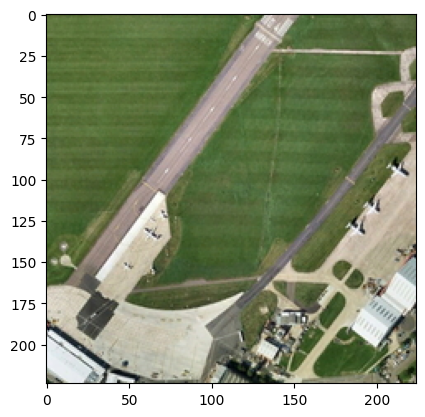

Greedy: pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches pitches
airport_349


In [ ]:
#z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(pic)

In [ ]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [ ]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

['the airport is very large ',
 'next to the airport is green grass ',
 'next to the airport is green grass ',
 'the airport is very large ',
 'the airport is very large ']

airport_350
Greedy Search Caption: rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails rails

Reference 1: ['there are many bare land near the airport ', 'many white planes were parked at the airport ', 'many white planes were parked at the airport ', 'there are many bare land near the airport ', 'there are many bare land near the airport ']



TypeError: Fraction.__new__() got an unexpected keyword argument '_normalize'

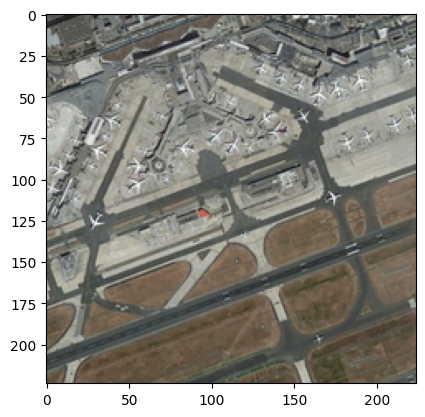

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
print(pic)
img = '/Users/koushik/Documents/MP/datasets/RSICD/RSICD_images/stadium_251.jpg'
e = encoding_test[pic].reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))